In [148]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from datetime import date,timedelta

In [149]:
df = pd.read_csv('data.csv.zip', encoding="ISO-8859-1")

In [150]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [147]:
df.Country.value_counts()

United Kingdom          485123
Germany                   9040
France                    8407
EIRE                      7890
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1966
Portugal                  1501
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Unspecified                446
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     295
Hong Kong                  284
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon 

In [59]:
df.CustomerID.fillna(0)

0         17850.0
1         17850.0
2         17850.0
3         17850.0
4         17850.0
           ...   
541904    12680.0
541905    12680.0
541906    12680.0
541907    12680.0
541908    12680.0
Name: CustomerID, Length: 541909, dtype: float64

In [ ]:
df.CustomerID.fillna(0)

In [ ]:
df.CustomerID.fillna(0)

In [63]:
df = df.query('Quantity > 0')

<AxesSubplot:>

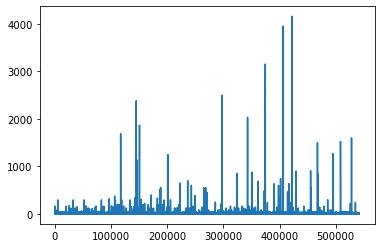

In [54]:
df.UnitPrice.plot()

In [55]:
df.UnitPrice.describe()

count    397881.000000
mean          3.096038
std          17.938862
min           0.001000
25%           1.250000
50%           1.950000
75%           3.750000
max        4161.060000
Name: UnitPrice, dtype: float64

In [17]:
df['CustomerID'].nunique()

4372

In [18]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [65]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

In [66]:
df['total_sum'] = df.UnitPrice*df.Quantity

In [32]:
df.UnitPrice.min()

-11062.06

In [67]:
last_date = df['InvoiceDate'].max()
rfmTable = df.reset_index().groupby('CustomerID').agg({'InvoiceDate': lambda x: (last_date - x.max()).days,
                                                 'InvoiceNo': lambda x: len(x), 
                                                 'total_sum': lambda x: x.sum()})
rfmTable.rename(columns={'InvoiceDate': 'recency', 
                          'InvoiceNo': 'frequency', 
                          'total_sum': 'monetary_value'}, inplace=True)

In [68]:
quantiles = rfmTable.quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()
segmented_rfm = rfmTable

In [69]:
def RScore(x,p,d):
     if x <= d[p][0.20]:
         return 1
     elif x <= d[p][0.40]:
         return 2
     elif x <= d[p][0.60]: 
         return 3
     elif x<=d[p][0.80]:
         return 4
     else:
         return 5

segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(RScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(RScore, args=('monetary_value',quantiles,))
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
print(segmented_rfm.head())

            recency  frequency  monetary_value  r_quartile  f_quartile  \
CustomerID                                                               
12346.0         325          1        77183.60           5           1   
12347.0           2        182         4310.00           1           5   
12348.0          75         31         1797.24           4           3   
12349.0          18         73         1757.55           2           4   
12350.0         310         17          334.40           5           2   

            m_quartile RFMScore  
CustomerID                       
12346.0              5      515  
12347.0              5      155  
12348.0              4      434  
12349.0              4      244  
12350.0              2      522  


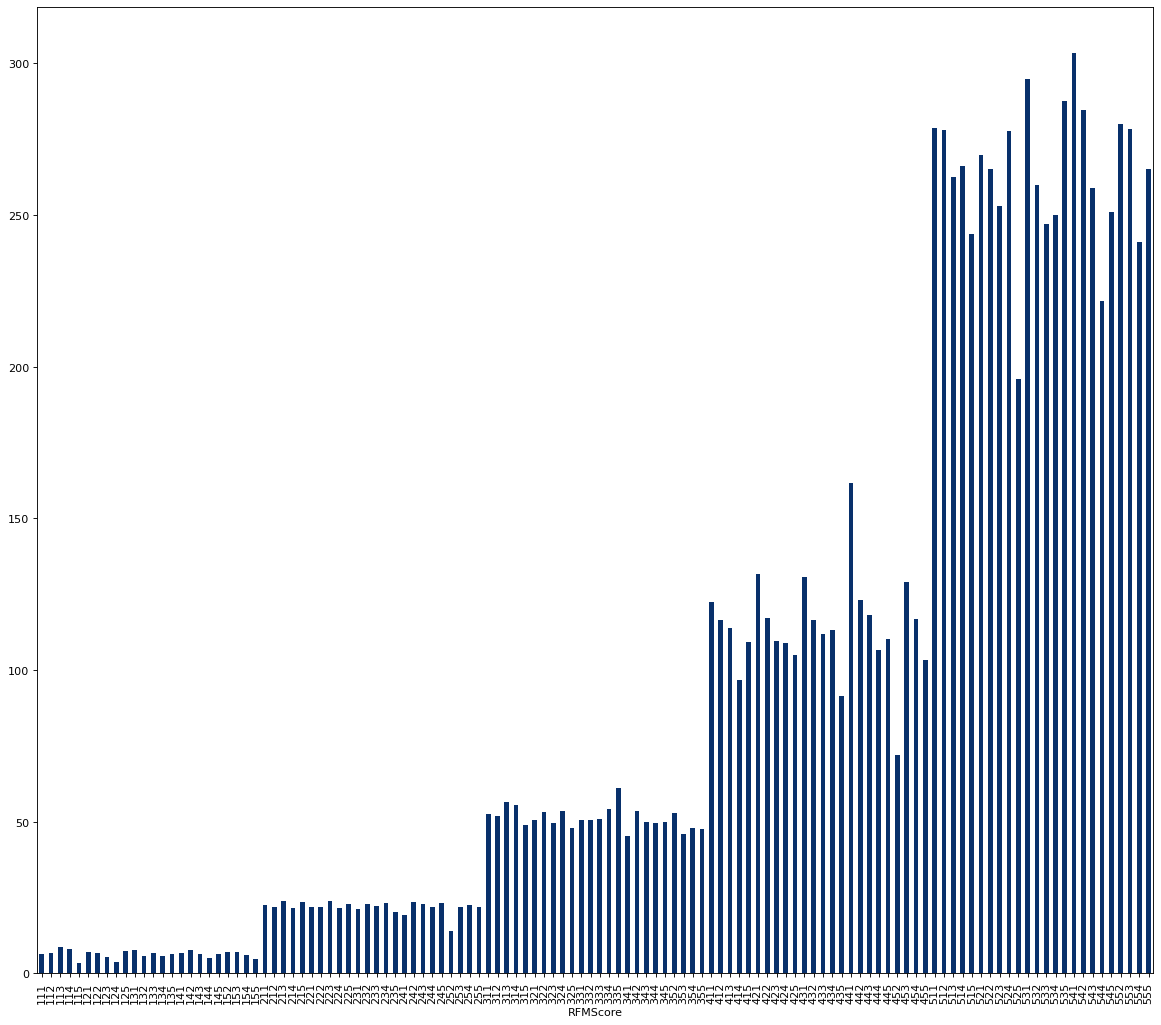

In [70]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFMScore').agg('recency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

Цель RFM анализа сформировать сегменты и в зависимости от сегмента воздействовать на них определенным образом. Например: предложить бонус, льготу, отправить push или email уведомление. Важно делать это таргетировано.

Эффект от использования RFM анализа может быть следующим: удержание клиентов, повышение дохода, повышение лояльность клиентов.

Примеры интерпретации сегментов RFM анализа:

R=5, F=5, M=5 — платят чаcто, много и недавно. Самые лояльным и активные пользователи. R=1, F=1, M=1 — платят мало, редко и давно. Скорее всего потерянные клиенты. Возможно не стоит предпринять действия по их возврату, если цена привлечения выше ожидаемой прибыли. R=1/2, F=4/5, M=4/5 — лояльные пользователи на грани ухода. Предлагаем им бонус, скидку и пытаемся их вернуть. R=4/5, F=1, M=1/2/3/4/5 — пользователи недавно совершили платеж. Пробуем их стимулировать покупать еще.

In [129]:
df_abc = df.groupby('CustomerID', as_index = False).agg({'total_sum': 'sum'}).sort_values('total_sum', ascending = False)

In [130]:
df_xyz = df.groupby('CustomerID', as_index = False).agg({'Quantity': 'sum'}).sort_values('Quantity', ascending = False)

In [131]:
total_sum = df_abc.total_sum.sum()
total_sum

8911407.904

In [132]:
total_sum_quan = df_xyz.Quantity.sum() 

In [133]:
df_abc['share_of_total']=df_abc.total_sum/total_sum*100

In [134]:
df_xyz['share_of_total_2']=df_xyz.Quantity/total_sum_quan*100

In [135]:
df_abc

,CustomerID,total_sum,share_of_total
1689,14646.0,280206.02,3.144352
4201,18102.0,259657.30,2.913763
3728,17450.0,194550.79,2.183166
3008,16446.0,168472.50,1.890526
1879,14911.0,143825.06,1.613943
...,...,...,...
3323,16878.0,13.30,0.000149
4098,17956.0,12.75,0.000143
3014,16454.0,6.90,0.000077
1793,14792.0,6.20,0.000070


In [136]:
df_abc['cum_sum']=df_abc.share_of_total.cumsum()

In [140]:
df_xyz['cum_sum']=df_xyz.share_of_total_2.cumsum()

In [137]:
df_abc.share_of_total.sum()

100.00000000000001

In [138]:
df_abc

,CustomerID,total_sum,share_of_total,cum_sum
1689,14646.0,280206.02,3.144352,3.144352
4201,18102.0,259657.30,2.913763,6.058115
3728,17450.0,194550.79,2.183166,8.241280
3008,16446.0,168472.50,1.890526,10.131807
1879,14911.0,143825.06,1.613943,11.745750
...,...,...,...,...
3323,16878.0,13.30,0.000149,99.999668
4098,17956.0,12.75,0.000143,99.999811
3014,16454.0,6.90,0.000077,99.999888
1793,14792.0,6.20,0.000070,99.999958


In [141]:
df_abc['abc'] = np.where(df_abc['cum_sum']<80, 'A', np.where((df_abc['cum_sum']<95), 'B', 'C'))

In [142]:
df_abc

,CustomerID,total_sum,share_of_total,cum_sum,abc
1689,14646.0,280206.02,3.144352,3.144352,A
4201,18102.0,259657.30,2.913763,6.058115,A
3728,17450.0,194550.79,2.183166,8.241280,A
3008,16446.0,168472.50,1.890526,10.131807,A
1879,14911.0,143825.06,1.613943,11.745750,A
...,...,...,...,...,...
3323,16878.0,13.30,0.000149,99.999668,C
4098,17956.0,12.75,0.000143,99.999811,C
3014,16454.0,6.90,0.000077,99.999888,C
1793,14792.0,6.20,0.000070,99.999958,C


In [143]:
df_xyz

,CustomerID,Quantity,share_of_total_2,cum_sum
1689,14646.0,196915,3.810413,3.810413
3008,16446.0,80997,1.567336,5.377750
1879,14911.0,80265,1.553172,6.930922
55,12415.0,77374,1.497229,8.428151
0,12346.0,74215,1.436101,9.864252
...,...,...,...,...
3219,16742.0,1,0.000019,99.999923
2558,15823.0,1,0.000019,99.999942
4098,17956.0,1,0.000019,99.999961
2540,15802.0,1,0.000019,99.999981


In [144]:
df_xyz.Quantity.describe()

count      4338.000000
mean       1191.289073
std        5046.081546
min           1.000000
25%         160.000000
50%         379.000000
75%         992.750000
max      196915.000000
Name: Quantity, dtype: float64

In [ ]:
df_abc['abc'] = np.where(df_abc['cum_sum']<80, 'A', np.where((df_abc['cum_sum']<95), 'B', 'C'))

In [122]:
1132/4338

0.26094974642692487

In [121]:
1464/4338

0.33748271092669435

In [120]:
1737/4338

0.4004149377593361

In [146]:
df_abc.merge(df_xyz, how='inner', on='CustomerID')

,CustomerID,total_sum,share_of_total,cum_sum_x,abc,Quantity,share_of_total_2,cum_sum_y
0,14646.0,280206.02,3.144352,3.144352,A,196915,3.810413,3.810413
1,18102.0,259657.30,2.913763,6.058115,A,64124,1.240835,13.708548
2,17450.0,194550.79,2.183166,8.241280,A,69993,1.354403,11.218655
3,16446.0,168472.50,1.890526,10.131807,A,80997,1.567336,5.377750
4,14911.0,143825.06,1.613943,11.745750,A,80265,1.553172,6.930922
...,...,...,...,...,...,...,...,...
4333,16878.0,13.30,0.000149,99.999668,C,12,0.000232,99.994292
4334,17956.0,12.75,0.000143,99.999811,C,1,0.000019,99.999961
4335,16454.0,6.90,0.000077,99.999888,C,3,0.000058,99.999555
4336,14792.0,6.20,0.000070,99.999958,C,2,0.000039,99.999748


In [ ]:
pd.crosstab(df.abc, df.xyz)

In [3]:
df_orders = pd.read_csv('olist_orders_dataset.csv')
df_payments = pd.read_csv('olist_order_payments_dataset.csv')


In [4]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [5]:
df_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [8]:
df_orders['order_delivered_carrier_date'] = pd.to_datetime(df_orders['order_delivered_carrier_date'])
df_payments = df_payments.set_index('order_id')
df_orders = df_orders.set_index('order_id')
order_payment = df_orders.join(df_payments)

In [13]:
last_date = order_payment['order_delivered_carrier_date'].max()
rfmTable = order_payment.reset_index().groupby('customer_id').agg({'order_delivered_carrier_date': lambda x: (last_date - x.max()).days,
                                                 'order_id': lambda x: len(x), 
                                                 'payment_value': lambda x: x.sum()})
rfmTable.rename(columns={'order_delivered_carrier_date': 'recency', 
                          'order_id': 'frequency', 
                          'payment_value': 'monetary_value'}, inplace=True)

In [15]:
quantiles = rfmTable.quantile(q=[0.20, 0.40, 0.60, 0.80])
quantiles = quantiles.to_dict()
segmented_rfm = rfmTable

In [16]:
def RScore(x,p,d):
     if x <= d[p][0.20]:
         return 1
     elif x <= d[p][0.40]:
         return 2
     elif x <= d[p][0.60]: 
         return 3
     elif x<=d[p][0.80]:
         return 4
     else:
         return 5

segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(RScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(RScore, args=('monetary_value',quantiles,))
segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str) + segmented_rfm.f_quartile.map(str) + segmented_rfm.m_quartile.map(str)
print(segmented_rfm.head())

                                  recency  frequency  monetary_value  \
customer_id                                                            
00012a2ce6f8dcda20d059ce98491703    298.0          1          114.74   
000161a058600d5901f007fab4c27140    419.0          1           67.41   
0001fd6190edaaf884bcaf3d49edf079    559.0          1          195.42   
0002414f95344307404f0ace7a26f1d5    388.0          1          179.35   
000379cdec625522490c315e70c7a9fb    160.0          1          107.01   

                                  r_quartile  f_quartile  m_quartile RFMScore  
customer_id                                                                    
00012a2ce6f8dcda20d059ce98491703           4           1           3      413  
000161a058600d5901f007fab4c27140           5           1           2      512  
0001fd6190edaaf884bcaf3d49edf079           5           1           4      514  
0002414f95344307404f0ace7a26f1d5           4           1           4      414  
000379cdec62552

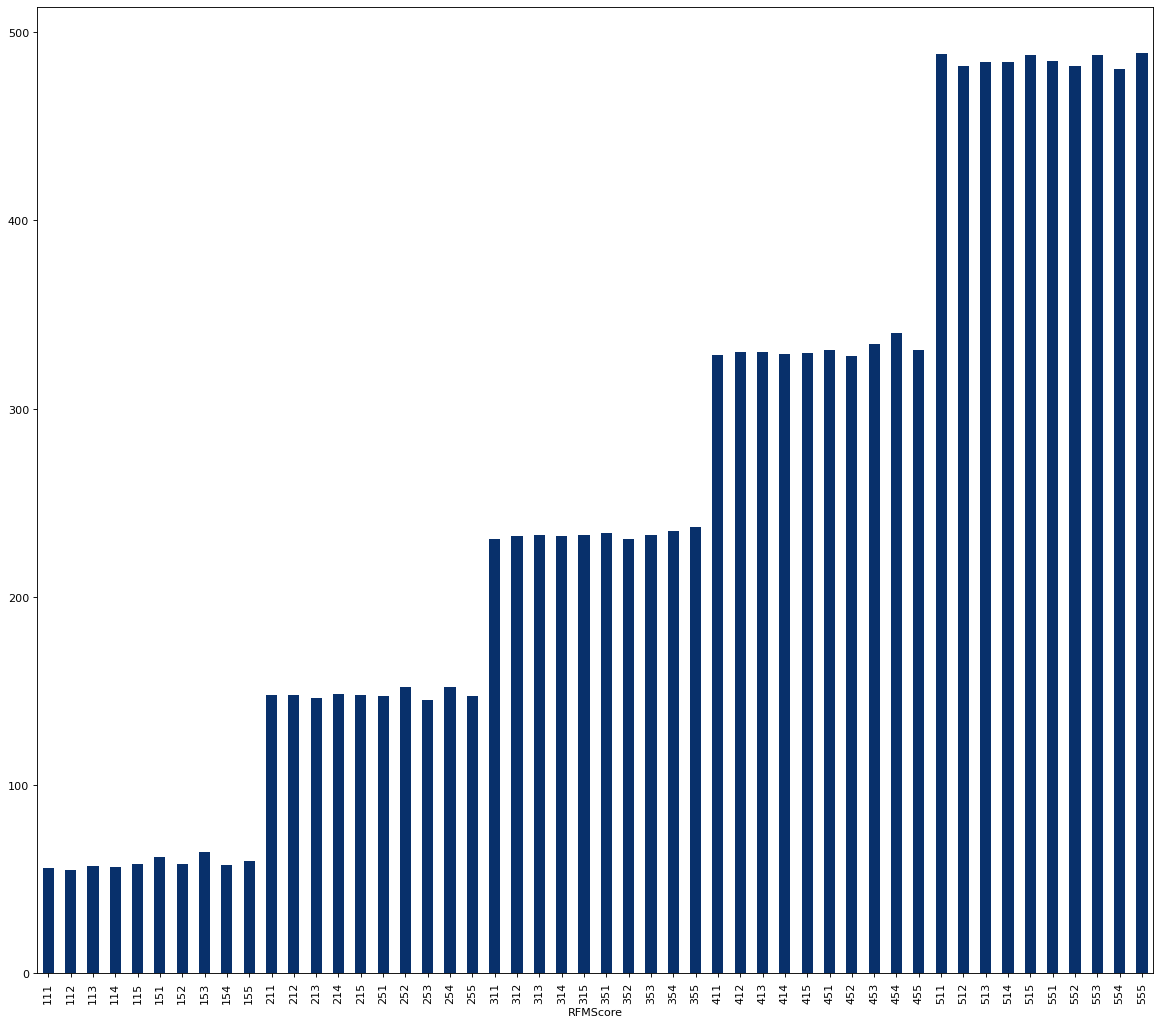

In [18]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
segmented_rfm.groupby('RFMScore').agg('recency').mean().plot(kind='bar', colormap='Blues_r')
plt.show()

Цель RFM анализа сформировать сегменты и в зависимости от сегмента воздействовать на них определенным образом. Например: предложить бонус, льготу, отправить push или email уведомление. Важно делать это таргетировано.

Эффект от использования RFM анализа может быть следующим: удержание клиентов, повышение дохода, повышение лояльность клиентов.

Примеры интерпретации сегментов RFM анализа:

R=5, F=5, M=5 — платят чаcто, много и недавно. Самые лояльным и активные пользователи.
R=1, F=1, M=1 — платят мало, редко и давно. Скорее всего потерянные клиенты. Возможно не стоит предпринять действия по их возврату, если цена привлечения выше ожидаемой прибыли.
R=1/2, F=4/5, M=4/5 — лояльные пользователи на грани ухода. Предлагаем им бонус, скидку и пытаемся их вернуть.
R=4/5, F=1, M=1/2/3/4/5 — пользователи недавно совершили платеж. Пробуем их стимулировать покупать еще.